# Requirements

In [1]:
import pandas as pd
pd.set_option('display.max_columns', 200)
import numpy as np
import geopandas as gpd
import nltk
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.lines as mlines
import scipy.stats as stats
import geoplot as gplt


from matplotlib.patches import Patch
import seaborn as sns
import gspread
from gspread_dataframe import get_as_dataframe, set_with_dataframe
from google.oauth2 import service_account # based on google-auth library
import sddk

from functools import partial
from shapely.ops import transform
import pyproj

In [72]:
# global parameters for plots
plt.style.use("fast")
plt.rcParams['figure.dpi'] = 300
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams['font.size'] = 8

def save_figure(fig, fig_name):
    #each figure to be saved in four different versions
    fig.savefig("../figures/" + fig_name + ".eps", format="eps")
    fig.savefig("../figures/" + fig_name + ".png")
    s.write_file(figpath + fig_name + ".eps", fig)
    s.write_file(figpath + fig_name + ".png", fig)

In [3]:
# to access gsheet, you need Google Service Account key json file
# I have mine located in my personal space on sciencedata.dk, so I read it from there:
s = sddk.cloudSession("sciencedata.dk", "SDAM_root", "648597@au.dk")
figpath = "SDAM_data/social_diversity/socdiv_figures/"

connection with shared folder established with you as its owner
endpoint variable has been configured to: https://sciencedata.dk/files/SDAM_root/


In [4]:
file_data = s.read_file("https://sciencedata.dk/files/ServiceAccountsKey.json", "dict")
credentials = service_account.Credentials.from_service_account_info(file_data)
gc = gspread.Client(auth=credentials.with_scopes(['https://spreadsheets.google.com/feeds', 'https://www.googleapis.com/auth/drive']))
socdiv_results = gc.open_by_url("https://docs.google.com/spreadsheets/d/1kACGBS9Xdno7FL2fPZ-vCOu4SSh9uUaZmGvnEghVs_A/edit?usp=sharing")

# Import datasets

In [5]:
LIRE = gpd.read_parquet("../data/large_data/LIREg_occupsorgs.parquet")
LIRE.head(5)

,EDCS-ID,publication,province,province_list,place,place_list,end_yr_list,notes_dating,status_list,inscr_type,status_notation,inscr_process,notes_references,notes_comments,inscription,inscription_stripped_final,Links,dating from,dating to,status,Latitude,Longitude,photo,Material,Comment,EDH-ID,language_EDCS,clean_text_interpretive_word_EDCS,responsible_individual,type_of_inscription,letter_size,literature,work_status,height,diplomatic_text,people,depth,material,type_of_monument,province_label,width,transcription,country,uri,findspot_ancient,last_update,modern_region,findspot_modern,edh_geography_uri,commentary,trismegistos_uri,external_image_uris,fotos,idno_tm,placenames_refs,text_edition,origdate_text,layout_execution,layout_execution_text,support_objecttype,support_objecttype_text,support_material,support_material_text,support_decoration,keywords_term,keywords_term_text,type_of_inscription_clean,type_of_inscription_certainty,height_cm,width_cm,depth_cm,material_clean,type_of_monument_clean,type_of_monument_certainty,province_label_clean,province_label_certainty,country_clean,country_certainty,findspot_ancient_clean,findspot_ancient_certainty,modern_region_clean,modern_region_certainty,findspot_modern_clean,findspot_modern_certainty,findspot_clean,findspot_certainty,origdate_text_clean,clean_text_conservative,clean_text_interpretive_sentence,findspot,year_of_find,present_location,religion,geography,social_economic_legal_history,military,not_after,language,not_before,coordinates,clean_text_interpretive_word,urban_context,within_rome,nearest_city,city_id_hanson,city_pop_est,city_geometry,nearest_city_type,nearest_city_dist,type_of_inscription_auto,type_of_inscription_auto_prob,geometry,is_western,large_city_ID,large_city_geo,large_city_dist,medium_city_ID,medium_city_geo,medium_city_dist,small_city_ID,small_city_geo,small_city_dist,urban_context_alt,occups,occups_N,organizations,organizations_N
0,EDCS-03700724,"ZPE-108-159 = Thesprotia 00001 = AE 1993, 0140...",Achaia,Achaia,Agios Athanasios / Photike,"['Agios Athanasios', 'Photike']",313,,"['Augusti/Augustae', 'litterae erasae', 'ordo ...",tituli honorarii,"['Augusti/Augustae', 'ordo equester', 'tria no...",litterae erasae,,,Fortissimo et Piis/simo Caesari d(omino) n(ost...,Fortissimo et Piis/simo Caesari d(omino) n(ost...,http://db.edcs.eu/epigr/partner.php?s_language...,309.0,313,Augusti/Augustae; litterae erasae; ordo equest...,39.451218,20.766767,http://db.edcs.eu/epigr/bilder.php?bilder.php?...,None,None,HD052964,None,Fortissimo et Piissimo Caesari domino nostro G...,Cowey,honorific inscription,3-5.3 cm,"AE 1993, 1406.; V. Papadopoulou, AD 43 B, 1988...",checked with photo,99 cm,FORTISSIMO ET PIIS / SIMO CAESARI D N / GAL VA...,"[{'name': 'Gal. Val. [[Maximiano]]', 'nomen': ...",67 cm,None,statue base,Epirus,67 cm,Fortissimo et piis/simo Caesari d(omino) n(ost...,Greece,https://edh-www.adw.uni-heidelberg.de/edh/insc...,Photike,2014-09-16,Ípeiros,Paramythía,https://edh-www.adw.uni-heidelberg.de/edh/geog...,None,https://www.trismegistos.org/text/121715,{ },{ },121715,"['http://www.trismegistos.org/place/000655', '...",Fortissimo et piissimo Caesari...,309 AD – 313 AD,21,unbestimmt,57.0,Statuenbasis,138,unbestimmt,1000.0,69,Ehreninschrift,honorific inscription,Certain,99.0,67.0,67.0,NULL,statue base,Certain,Epirus,Certain,Greece,Certain,Photike,Certain,Ípeiros,Certain,Paramythía,Certain,Agios Athanasios,Certain,309 AD – 313 AD,Fortissimo et piissimo Caesari d n Gal Val P F...,Fortissimo et piissimo Caesari domino nostro G...,Agios Athanasios,None,Fragma Kalama,None,data available,None,None,313.0,Latin,309.0,"[20.7668, 39.4512]",Fortissimo et piissimo Caesari domino nostro G...,rest,False,Dodona,31,1000.0,"[20.787767, 39.546432]",minor,0.097513,honorific inscription,1.0,POINT (20.76680 39.45120),False,65,"[20.733395, 39.026505]",47237.78,7,"[20.987, 39.158]",37687.28,31,"[20.787767, 39.546432]",10725.84,rural,[],0,[],0
1,EDCS-03300852,"AE 1995, 01409",Achaia,Achaia,Alea / Tege

In [6]:
roman_cities = gpd.read_file("../data/roman_cities_pop.geojson")
pleiades_regions = gpd.read_file("../data/pleiades_regions.geojson")

# Spatial distribution of inscriptions by context

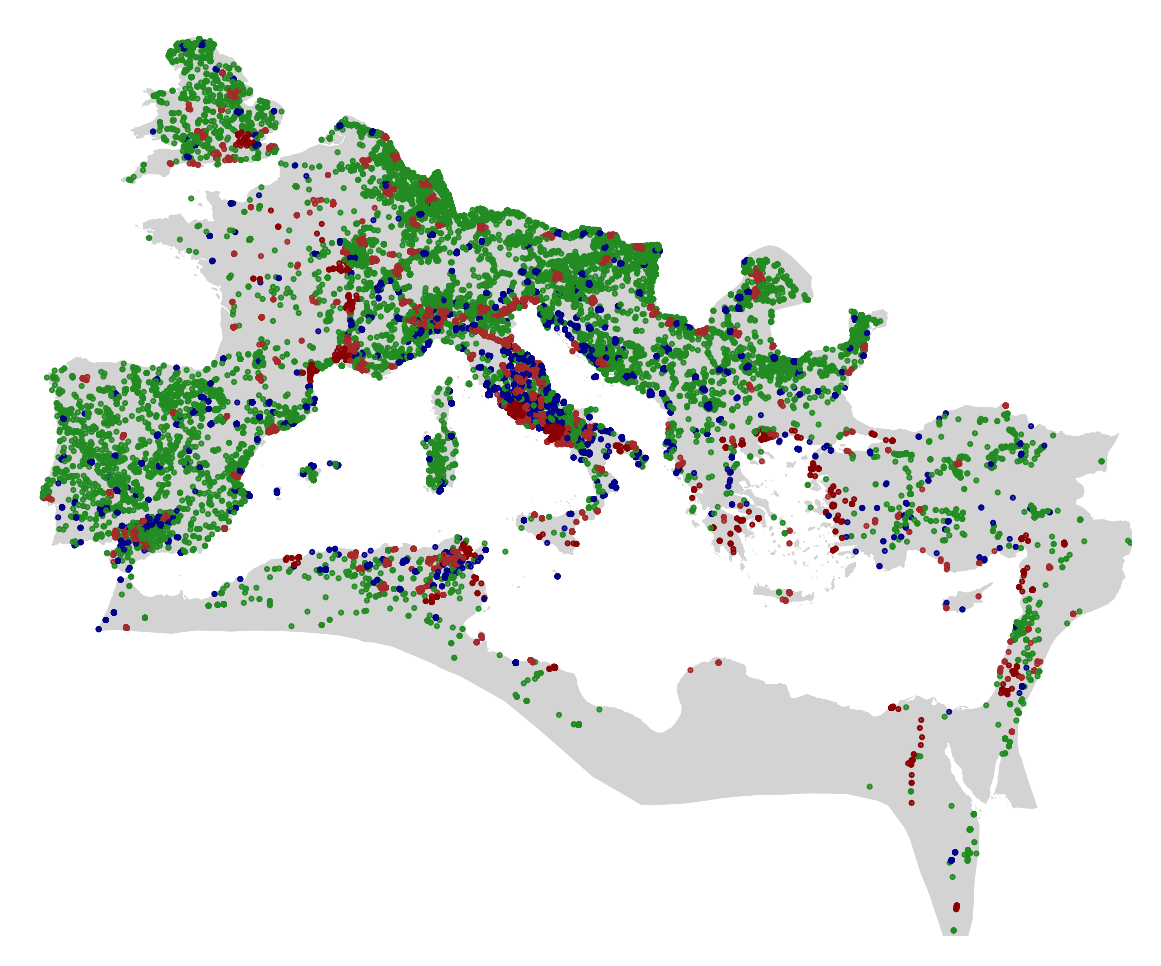

In [195]:
context_color_dict = {"large" : "darkred",
                      "medium" : "brown",
                      "small" : "darkblue",
                      "rural" : "forestgreen"}
colors = LIRE["urban_context_alt"].apply(lambda x: context_color_dict[x])

fig, ax = plt.subplots()
pleiades_regions.plot(ax=ax, color="lightgray")
LIRE.plot(ax=ax, markersize=0.2, color=colors)
ax.set_axis_off()
ax.set_xlim(-10, 41)
ax.set_ylim(23, 55.5)
plt.show()

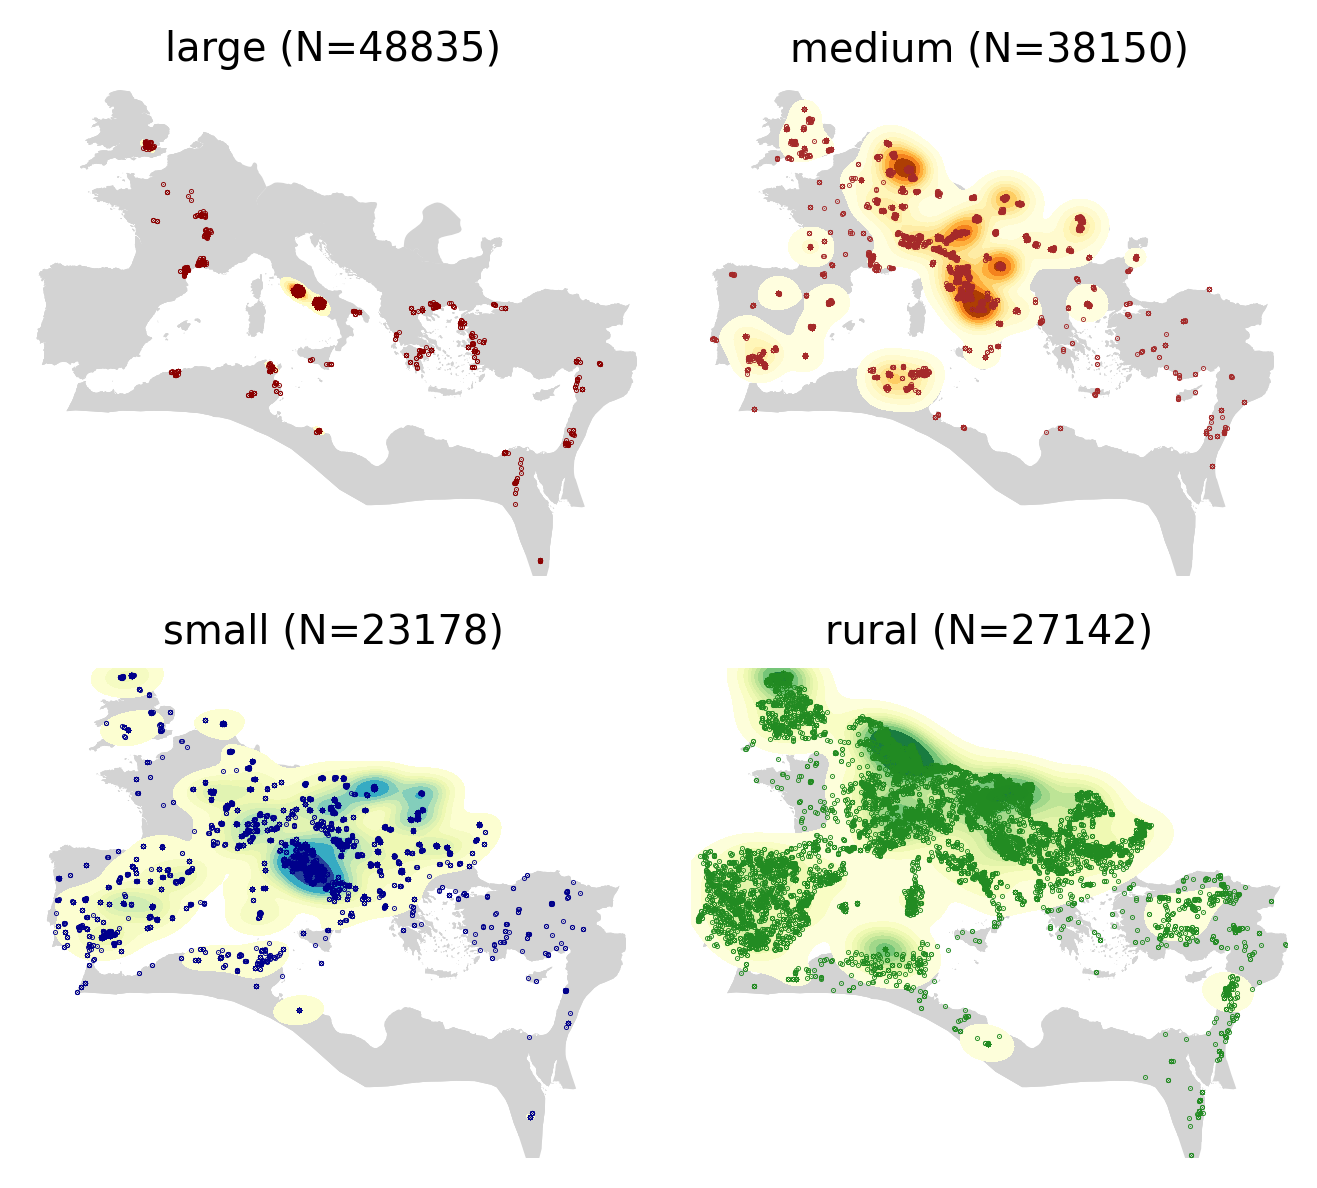

In [54]:
#color maps: https://matplotlib.org/stable/tutorials/colors/colormaps.html
#colors: https://matplotlib.org/stable/gallery/color/named_colors.html
fig, axs = plt.subplots(2,2, tight_layout=True)


for ax, context, color, cmap in zip(
        axs.ravel(),
        ["large", "medium", "small", "rural"],
        ["darkred", "brown", "darkblue","forestgreen"],
        ["YlOrRd", "YlOrBr", "YlGnBu", "YlGn"]):
    pleiades_regions.plot(ax=ax, color="lightgray")
    df = LIRE[LIRE["urban_context_alt"]==context]
    gplt.kdeplot(df, cmap=plt.get_cmap(cmap), ax=ax, shade=True, zorder=2)
    df.plot(ax=ax, marker=".", markersize=0.2, color=color, zorder=3)
    ax.set_axis_off()
    ax.set_xlim(-10, 41)
    ax.set_ylim(23, 55.5)
    ax.set_title(context + " (N={0})".format(str(len(df))))


In [39]:
save_figure(fig, "lire_spatial_by_context")

A file with the same name ("lire_spatial_by_context.eps") already exists in this location.
Your <class 'matplotlib.figure.Figure'> object has been succefully written as "https://sciencedata.dk/files/SDAM_root/SDAM_data/social_diversity/socdiv_figures/lire_spatial_by_context.eps"
A file with the same name ("lire_spatial_by_context.png") already exists in this location.
Your <class 'matplotlib.figure.Figure'> object has been succefully written as "https://sciencedata.dk/files/SDAM_root/SDAM_data/social_diversity/socdiv_figures/lire_spatial_by_context.png"


# Occupations and organizations by context

In [8]:
# OCCUPATIONS frequency accross location categories
for context in ["large", "medium", "small", "rural"]:
    print(context, LIRE[LIRE["urban_context_alt"]==context]["occups_N"].sum() / len(LIRE[LIRE["urban_context_alt"]==context]))

large 0.0501689362137811
medium 0.03583224115334207
small 0.03964966778842005
rural 0.018716380517279495


In [9]:
# OCCUPATIONS frequency accross location categories - WESTERN
for context in ["large", "medium", "small", "rural"]:
    print(context, LIRE[(LIRE["urban_context_alt"]==context) & (LIRE["is_western"])]["occups_N"].sum() / len(LIRE[LIRE["urban_context_alt"]==context]))

large 0.04961605405958841
medium 0.033132372214941024
small 0.03391146777116231
rural 0.016026821899638936


In [10]:
# OCCUPATIONS frequency accross location categories
for context in ["big", "middle", "rest"]:
    print(context, LIRE[LIRE["urban_context"]==context]["occups_N"].sum() / len(LIRE[LIRE["urban_context"]==context]))

big 0.05032925682031985
middle 0.038016734469098076
rest 0.020021173246979697


In [11]:
# ORGANIZATIONS frequency accross location categories
for context in ["large", "medium", "small", "rural"]:
    print(context, LIRE[LIRE["urban_context_alt"]==context]["organizations_N"].sum() / len(LIRE[LIRE["urban_context_alt"]==context]))

large 0.01937135251356609
medium 0.010406290956749673
small 0.012770730865475883
rural 0.006373885491120773


In [13]:
# ORGANIZATIONS frequency accross location categories
for context in ["large", "medium", "small", "rural"]:
    print(context, LIRE[(LIRE["urban_context_alt"]==context) & (LIRE["is_western"])]["organizations_N"].sum() / len(LIRE[LIRE["urban_context_alt"]==context]))

large 0.019289444046278283
medium 0.009672346002621231
small 0.010440935369747174
rural 0.004679095129319874


In [14]:
for context in ["big", "middle", "rest"]:
    print(context, LIRE[LIRE["urban_context"]==context]["organizations_N"].sum() / len(LIRE[LIRE["urban_context"]==context]))

big 0.019346394535563825
middle 0.011724787266170435
rest 0.006414248349732221


### results from previous version
big 0.03106466522148145
middle 0.01952354728109289
rest 0.010306389338647403

# Closer look at urban contexts...

# Bootstrap test

bawed on Brezina 2018, p. 232, drawing on Lijffijt 2016
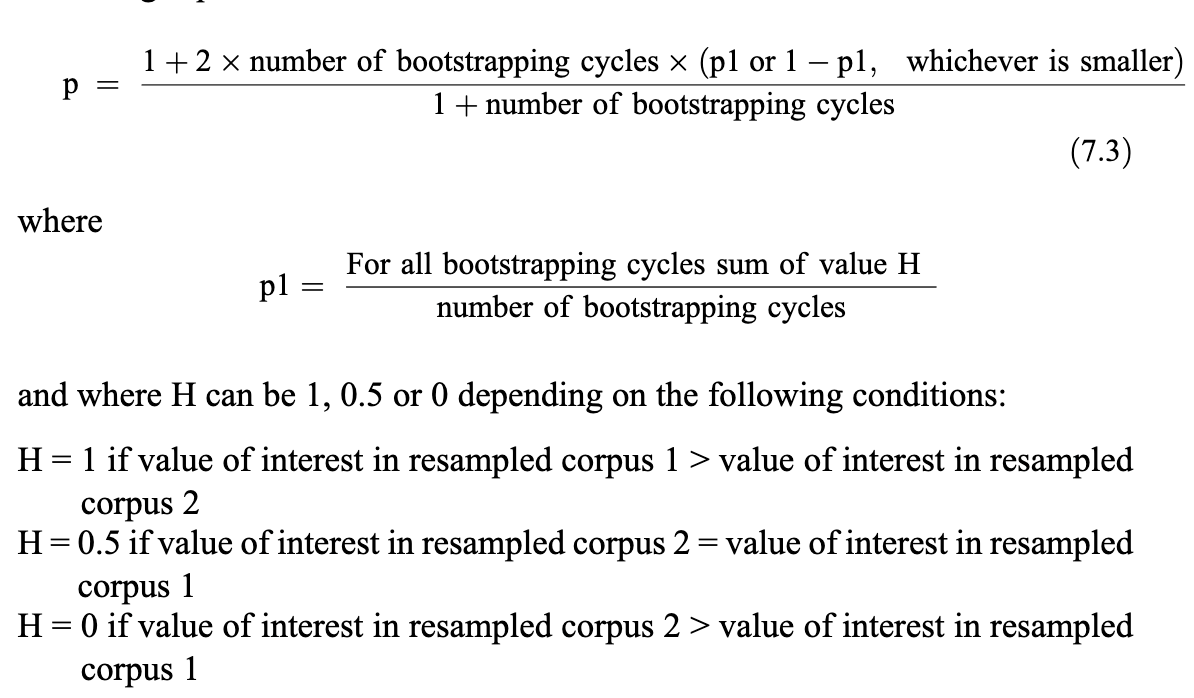

In [15]:
def get_bootstrap(df, n_of_bootstraps, bootstrap_size, column, row_function=None):
    bootstrap_values = []
    for n in range(n_of_bootstraps):
        sample_df = df.sample(bootstrap_size, replace=True)
        if row_function == None:
            bootstrap_values.append(sample_df[column].sum())
        else:
            bootstrap_values.append(sample_df[column].apply(row_function).mean())
    return bootstrap_values

def get_statistics(df1, df2, n_of_bootstraps, bootstrap_size, column, row_function=None):
    bootstrap_test_values = []
    df1_values = get_bootstrap(df1, n_of_bootstraps, bootstrap_size, column, row_function)
    df2_values = get_bootstrap(df2, n_of_bootstraps, bootstrap_size, column, row_function)
    # H values
    H_list = []
    for n in range(n_of_bootstraps):
        if df1_values[n] == df2_values[n]:
            H_list.append(0.5)
        else:
            if df1_values[n] > df2_values[n]:
                H_list.append(1)
            else:
                H_list.append(0)
    # CONFIDENCE INTERVAL (950) for the difference
    difference = np.array(df1_values) - np.array(df2_values)
    CI95 = (np.percentile(difference, 2.5), np.percentile(difference, 97.5))
    # COHENS DELTA
    pooled_sd = np.sqrt(((len(df1_values) - 1) * ((np.std(df1_values)**2))) + ((len(df2_values) - 1) * (np.std(df2_values)**2)) / (len(df1_values) + len(df2_values) + 2))
    cohens_delta = (np.mean(df1_values) - np.mean(df2_values)) / pooled_sd
    return H_list, cohens_delta, CI95, [df1_values, df2_values]

def bootstrap_test(df1, df2, n_of_bootstraps, bootstrap_size, column, row_function=None):
    H_values, cohens_delta, CI95, data = get_statistics(df1, df2, 1000, 1000, column, row_function)
    p1 =  sum(H_values) / len(H_values)
    p = (1 + (2 * len(H_values) * np.min((p1, 1 - p1)))) / (1 + len(H_values))
    return p, cohens_delta, CI95, data

In [16]:
# test1 "get_bootstrap()"
df1_values = get_bootstrap(LIRE[LIRE["urban_context"]=="big"], 1000, 1000, "occups_N")
df2_values = get_bootstrap(LIRE[LIRE["urban_context"]=="middle"], 1000, 1000, "occups_N")

print(df1_values[:10])
print(df2_values[:10])

[48, 50, 46, 36, 52, 54, 57, 63, 55, 48]
[36, 38, 46, 48, 37, 32, 37, 52, 37, 36]


### Occupations - original urban contexts

In [17]:
# LIRE - occupations in BIG CITIES vs MIDDLE CITIES
p, cohens_d, CI95, edhcs_data_occups_big_middle = bootstrap_test(LIRE[LIRE["urban_context"]=="big"], LIRE[LIRE["urban_context"]=="middle"], 1000, 1000, "occups_N")
p, cohens_d, CI95

(0.31768231768231764, 0.03863342377053505, (-11.0, 37.02499999999998))

In [18]:
# LIRE - occuptions in MIDDLE CITIES vs. REST areas
p, cohens_d, CI95, edhcs_data_occups_middle_rest = bootstrap_test(LIRE[LIRE["urban_context"]=="middle"], LIRE[LIRE["urban_context"]=="rest"], 1000, 1000, "occups_N")
p, cohens_d, CI95

(0.05294705294705299, 0.06678636275587489, (0.0, 39.0))

In [19]:
# LIRE - occupations in BIG CITIES vs REST areas
p, cohens_d, CI95, edhcs_data_occups_big_rest = bootstrap_test(LIRE[LIRE["urban_context"]=="big"], LIRE[LIRE["urban_context"]=="rest"], 1000, 1000, "occups_N")
p, cohens_d, CI95

(0.0049950049950049985, 0.10318740544669225, (10.0, 52.0))

### Occupations - alternative urban contexts

In [20]:
# LIRE - occupations URBAN vs RURAL areas
p, cohens_d, CI95, lire_occups_urban_rural = bootstrap_test(LIRE[~(LIRE["urban_context_alt"]=="rural")], LIRE[LIRE["urban_context_alt"]=="rural"], 1000, 1000, "occups_N")
p, cohens_d, CI95

(0.005994005994005887, 0.0914545799723842, (5.0, 45.0))

In [21]:
# LIRE - occupations LARGE vs MEDIUM city areas
p, cohens_d, CI95, lire_occups_large_medium = bootstrap_test(LIRE[LIRE["urban_context_alt"]=="large"], LIRE[LIRE["urban_context_alt"]=="medium"], 1000, 1000, "occups_N")
p, cohens_d, CI95

(0.2647352647352647,
 0.04345664791622897,
 (-12.024999999999999, 40.02499999999998))

In [22]:
# LIRE - occupations SMALL vs RURAL areas
p, cohens_d, CI95, lire_occups_small_rural = bootstrap_test(LIRE[LIRE["urban_context_alt"]=="small"], LIRE[LIRE["urban_context_alt"]=="rural"], 1000, 1000, "occups_N")
p, cohens_d, CI95

(0.032967032967032996, 0.08600508551844444, (3.0, 40.0))

### Organizations - original urban contexts

In [23]:
# LIRE - organizations in BIG CITIES vs MIDDLE CITIES
p, cohens_d, CI95, edhcs_data_orgs_big_middle = bootstrap_test(LIRE[LIRE["urban_context"]=="big"], LIRE[LIRE["urban_context"]=="middle"], 1000, 1000, "organizations_N")
p, cohens_d, CI95

(0.5334665334665334, 0.02078116152525795, (-9.0, 39.02499999999998))

In [24]:
# LIRE - organizations in MIDDLE CITIES vs. REST areas
p, cohens_d, CI95, edhcs_data_orgs_middle_rest = bootstrap_test(LIRE[LIRE["urban_context"]=="middle"], LIRE[LIRE["urban_context"]=="rest"], 1000, 1000, "organizations_N")
p, cohens_d, CI95

(0.3296703296703296, 0.03859020332395209, (-5.0, 17.0))

In [25]:
# LIRE - organizations in BIG CITIES vs. REST areas
p, cohens_d, CI95, edhcs_data_orgs_big_rest = bootstrap_test(LIRE[LIRE["urban_context"]=="big"], LIRE[LIRE["urban_context"]=="rest"], 1000, 1000, "organizations_N")
p, cohens_d, CI95

(0.14785214785214787, 0.03639407273205509, (-3.0, 42.0))

### Organizations - alternative urban contexts

In [26]:
# LIRE - occupations URBAN vs RURAL areas
p, cohens_d, CI95, lire_orgs_urban_rural = bootstrap_test(LIRE[~(LIRE["urban_context_alt"]=="rural")], LIRE[LIRE["urban_context_alt"]=="rural"], 1000, 1000, "organizations_N")
p, cohens_d, CI95

(0.24475524475524477, 0.03512141039101891, (-5.0, 28.0))

In [27]:
# LIRE - occupations LARGE vs MEDIUM areas
p, cohens_d, CI95, lire_orgs_large_medium = bootstrap_test(LIRE[LIRE["urban_context_alt"]=="large"], LIRE[LIRE["urban_context_alt"]=="medium"], 1000, 1000, "organizations_N")
p, cohens_d, CI95

(0.4105894105894105, 0.02609442213884263, (-8.0, 40.0))

In [28]:
# LIRE - occupations SMALL vs RURAL areas
p, cohens_d, CI95, lire_orgs_small_rural = bootstrap_test(LIRE[LIRE["urban_context_alt"]=="small"], LIRE[LIRE["urban_context_alt"]=="rural"], 1000, 1000, "organizations_N")
p, cohens_d, CI95

(0.22077922077922074, 0.05055781509641075, (-6.0, 17.0))

In [29]:
# LIRE - occupations SMALL vs RURAL areas
p, cohens_d, CI95, lire_orgs_large_rural = bootstrap_test(LIRE[LIRE["urban_context_alt"]=="large"], LIRE[LIRE["urban_context_alt"]=="rural"], 1000, 1000, "organizations_N")
p, cohens_d, CI95

(0.13586413586413587, 0.03646139352037355, (-4.0, 44.02499999999998))

## Box plot - original urban contexts

In [30]:
labels=[
    "cities (pop.≥30K)",
    "cities (pop.>1K)",
    "rural or minor cities"
]

In [31]:
stat_series = []
for label, data in zip(labels, edhcs_data_occups_big_middle + [edhcs_data_occups_middle_rest[1]]):
    stat_series.append(pd.Series(data).describe())
    
for label, data in zip(labels, edhcs_data_orgs_big_middle + [edhcs_data_orgs_middle_rest[1]]):
    stat_series.append(pd.Series(data).describe())
    

In [32]:
contexts = labels + labels
contexts  = [context.replace("\n", " ") for context in contexts]
measurements = ["occups. per 1,000 ins."] * 3 + ["orgs. per 1,000 ins."] * 3

occups_orgs_contexts_descriptive = pd.DataFrame([measurements, contexts], index=["measurement","context"]).T.join(pd.DataFrame(stat_series))

for col in ["count",  "min", "25%", "50%", "75%", "max"]:
    occups_orgs_contexts_descriptive[col] = occups_orgs_contexts_descriptive[col].astype(int)
occups_orgs_contexts_descriptive.drop("count", inplace=True, axis=1)
#occups_orgs_contexts_descriptive.rename(columns={"count" : "N of bootstraps"}, inplace=True)
occups_orgs_contexts_descriptive = occups_orgs_contexts_descriptive.round(2)
occups_orgs_contexts_descriptive

,measurement,context,mean,std,min,25%,50%,75%,max
0,"occups. per 1,000 ins.",cities (pop.≥30K),50.55,9.94,25,44,50,57,86
1,"occups. per 1,000 ins.",cities (pop.>1K),38.42,8.23,17,33,38,43,83
2,"occups. per 1,000 ins.",rural or minor cities,19.94,5.35,5,16,20,23,40
3,"orgs. per 1,000 ins.",cities (pop.≥30K),19.43,11.69,2,12,16,24,90
4,"orgs. per 1,000 ins.",cities (pop.>1K),11.75,4.23,1,9,11,14,31
5,"orgs. per 1,000 ins.",rural or minor cities,6.40,3.37,0,4,6,8,22


In [33]:
print(occups_orgs_contexts_descriptive.to_latex(index=False, bold_rows=True, multirow=True))

\begin{tabular}{llrrrrrrr}
\toprule
           measurement &               context &  mean &   std &  min &  25\% &  50\% &  75\% &  max \\
\midrule
occups. per 1,000 ins. &     cities (pop.≥30K) & 50.55 &  9.94 &   25 &   44 &   50 &   57 &   86 \\
occups. per 1,000 ins. &      cities (pop.>1K) & 38.42 &  8.23 &   17 &   33 &   38 &   43 &   83 \\
occups. per 1,000 ins. & rural or minor cities & 19.94 &  5.35 &    5 &   16 &   20 &   23 &   40 \\
  orgs. per 1,000 ins. &     cities (pop.≥30K) & 19.43 & 11.69 &    2 &   12 &   16 &   24 &   90 \\
  orgs. per 1,000 ins. &      cities (pop.>1K) & 11.75 &  4.23 &    1 &    9 &   11 &   14 &   31 \\
  orgs. per 1,000 ins. & rural or minor cities &  6.40 &  3.37 &    0 &    4 &    6 &    8 &   22 \\
\bottomrule
\end{tabular}



In [34]:
occups_orgs_contexts_descriptive.to_csv("../data/occups_orgs_contexts_descriptive.csv")

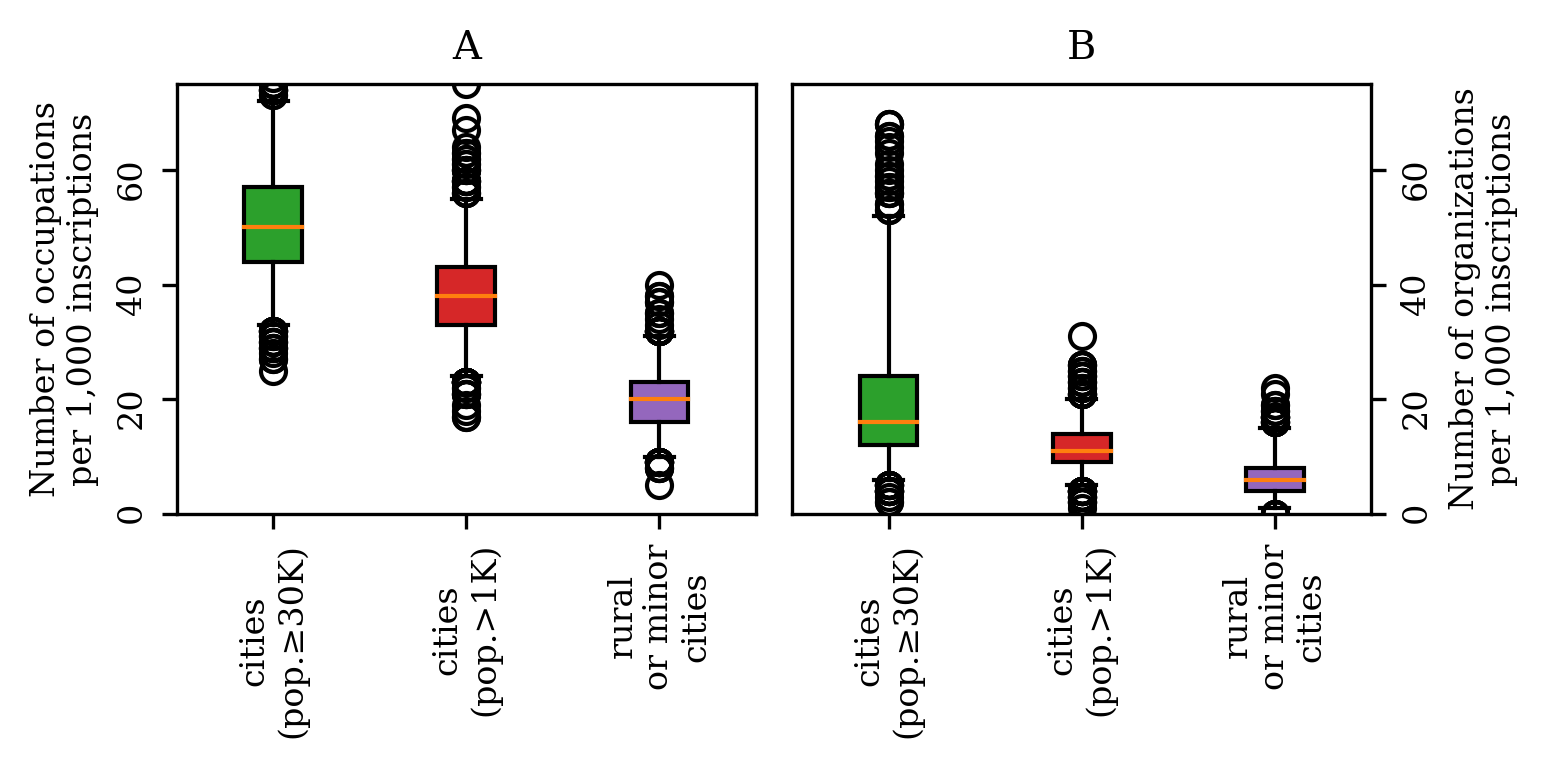

In [35]:

plt.style.use("fast")
plt.rcParams['figure.dpi'] = 300
plt.rcParams["font.family"] = "serif"
plt.rcParams['font.size'] = 8

tab_colors_list = list(mcolors.TABLEAU_COLORS.keys())

labels=[
    "cities\n(pop.≥30K)",
    "cities\n(pop.>1K)",
    "rural\nor minor\ncities"
]

fig, [ax1, ax2] = plt.subplots(1,2, figsize=[5.2,2.6], tight_layout=True)

bplot1 = ax1.boxplot(edhcs_data_occups_big_middle + [edhcs_data_occups_middle_rest[1]], whis=[2.5, 97.5], labels=labels, patch_artist=True)
ax1.set_title("A")
ax1.set_ylabel("Number of occupations\nper 1,000 inscriptions")
ax1.tick_params(labelrotation=90)
ax1.set_ylim(0,75)


bplot2 = ax2.boxplot(edhcs_data_orgs_big_middle + [edhcs_data_orgs_middle_rest[1]], whis=[2.5, 97.5], labels=labels, patch_artist=True)
ax2.set_title("B")
ax2.yaxis.set_label_position("right")
ax2.yaxis.tick_right()
ax2.set_ylabel("Number of organizations\nper 1,000 inscriptions")
ax2.tick_params(labelrotation=90)
ax2.set_ylim(0,75)




# fill with colors
colors =tab_colors_list[2:][:len(labels)]
for bplot in (bplot1, bplot2):
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)

## Box plot - alternative urban contexts

In [234]:
labels=[
    "large city",
    "medium city",
    "small city",
    "rural area"
]

In [260]:
labels * 2

['large city',
 'medium city',
 'small city',
 'rural area',
 'large city',
 'medium city',
 'small city',
 'rural area']

In [261]:
len(lire_occups_large_medium + lire_occups_small_rural)

4

In [262]:
stat_series = []
for label, data in zip(labels, lire_occups_large_medium + lire_occups_small_rural):
    stat_series.append(pd.Series(data).describe())

for label, data in zip(labels, lire_orgs_large_medium + lire_orgs_small_rural):
    stat_series.append(pd.Series(data).describe())

In [263]:
np.mean(lire_orgs_small_rural[0])

12.639

In [264]:
contexts = labels + labels
measurements = ["occups. per 1,000 ins."] * 4 + ["orgs. per 1,000 ins."] * 4

occups_orgs_contexts_descriptive = pd.DataFrame([measurements, contexts], index=["measurement","context"]).T.join(pd.DataFrame(stat_series))

for col in ["count",  "min", "25%", "50%", "75%", "max"]:
    occups_orgs_contexts_descriptive[col] = occups_orgs_contexts_descriptive[col].astype(int)
occups_orgs_contexts_descriptive.drop("count", inplace=True, axis=1)
occups_orgs_contexts_descriptive.rename(columns={"count" : "N of bootstraps"}, inplace=True)
occups_orgs_contexts_descriptive = occups_orgs_contexts_descriptive.round(2)
occups_orgs_contexts_descriptive

,measurement,context,mean,std,min,25%,50%,75%,max
0,"occups. per 1,000 ins.",large city,50.35,10.43,24,43,50,57,94
1,"occups. per 1,000 ins.",medium city,35.59,7.85,16,30,35,40,71
2,"occups. per 1,000 ins.",small city,40.03,7.56,11,35,40,45,68
3,"occups. per 1,000 ins.",rural area,18.76,5.40,5,15,18,22,45
4,"orgs. per 1,000 ins.",large city,19.28,11.84,2,11,16,24,90
5,"orgs. per 1,000 ins.",medium city,10.23,4.06,0,7,10,13,37
6,"orgs. per 1,000 ins.",small city,12.64,3.85,2,10,12,15,27
7,"orgs. per 1,000 ins.",rural area,6.39,3.67,0,4,6,8,30


In [266]:
print(occups_orgs_contexts_descriptive.to_latex(index=False, bold_rows=True, multirow=True))

\begin{tabular}{llrrrrrrr}
\toprule
           measurement &     context &  mean &   std &  min &  25\% &  50\% &  75\% &  max \\
\midrule
occups. per 1,000 ins. &  large city & 50.35 & 10.43 &   24 &   43 &   50 &   57 &   94 \\
occups. per 1,000 ins. & medium city & 35.59 &  7.85 &   16 &   30 &   35 &   40 &   71 \\
occups. per 1,000 ins. &  small city & 40.03 &  7.56 &   11 &   35 &   40 &   45 &   68 \\
occups. per 1,000 ins. &  rural area & 18.76 &  5.40 &    5 &   15 &   18 &   22 &   45 \\
  orgs. per 1,000 ins. &  large city & 19.28 & 11.84 &    2 &   11 &   16 &   24 &   90 \\
  orgs. per 1,000 ins. & medium city & 10.23 &  4.06 &    0 &    7 &   10 &   13 &   37 \\
  orgs. per 1,000 ins. &  small city & 12.64 &  3.85 &    2 &   10 &   12 &   15 &   27 \\
  orgs. per 1,000 ins. &  rural area &  6.39 &  3.67 &    0 &    4 &    6 &    8 &   30 \\
\bottomrule
\end{tabular}



In [267]:
occups_orgs_contexts_descriptive.to_csv("../data/occups_orgs_contexts_alt_descriptive.csv")

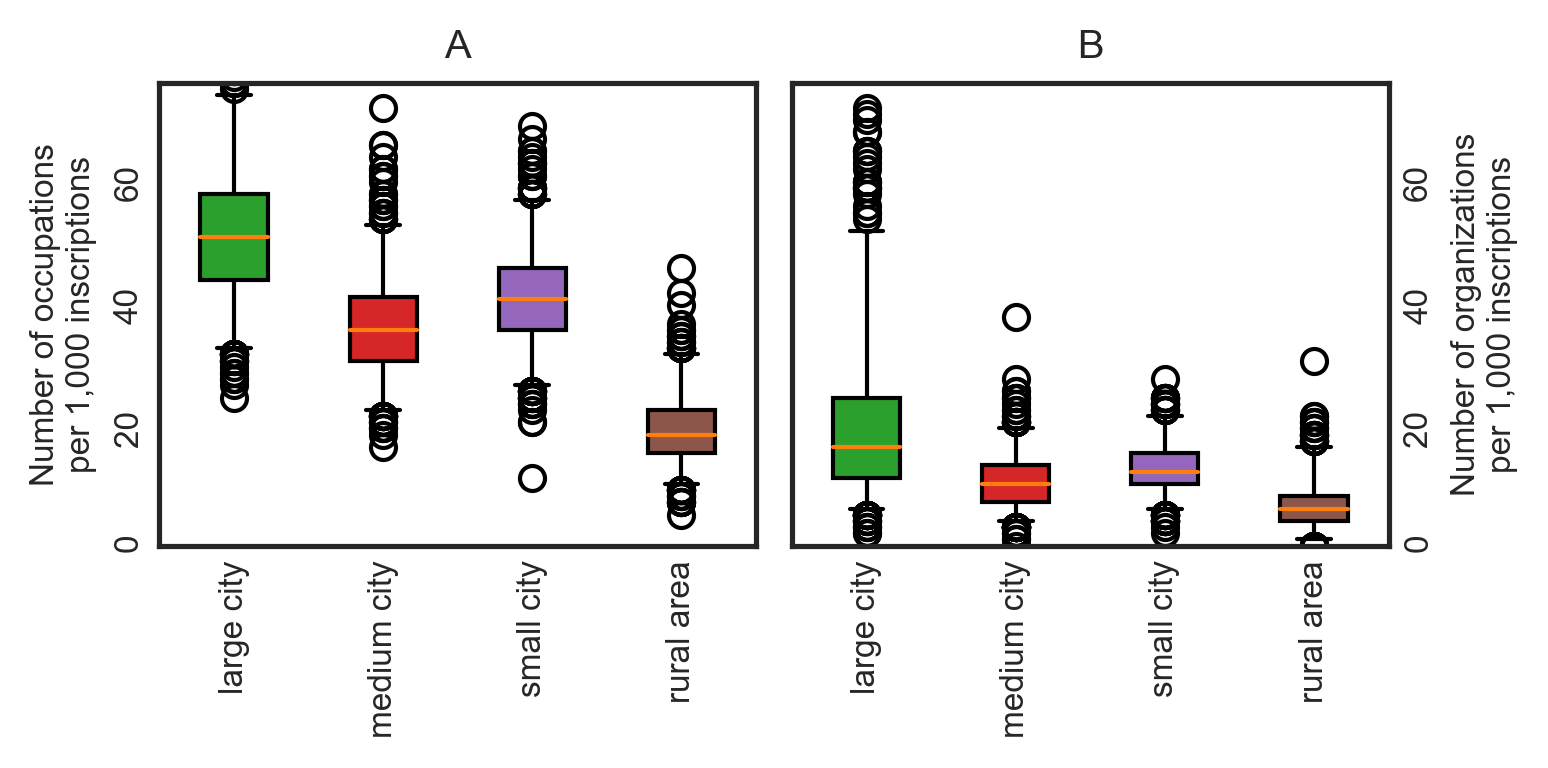

In [269]:
tab_colors_list = list(mcolors.TABLEAU_COLORS.keys())

fig, [ax1, ax2] = plt.subplots(1,2, figsize=[5.2,2.6], tight_layout=True)

bplot1 = ax1.boxplot(lire_occups_large_medium + lire_occups_small_rural, whis=[2.5, 97.5], labels=labels, patch_artist=True)
ax1.set_title("A")
ax1.set_ylabel("Number of occupations\nper 1,000 inscriptions")
ax1.tick_params(labelrotation=90)
ax1.set_ylim(0,75)


bplot2 = ax2.boxplot(lire_orgs_large_medium + lire_orgs_small_rural, whis=[2.5, 97.5], labels=labels, patch_artist=True)
ax2.set_title("B")
ax2.yaxis.set_label_position("right")
ax2.yaxis.tick_right()
ax2.set_ylabel("Number of organizations\nper 1,000 inscriptions")
ax2.tick_params(labelrotation=90)
ax2.set_ylim(0,75)

# fill with colors
colors =tab_colors_list[2:][:len(labels)]
for bplot in (bplot1, bplot2):
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)

In [270]:
save_figure(fig, "occups_orgs_by_context_alt_box")

A file with the same name ("occups_orgs_by_context_alt_box.eps") already exists in this location.
Your <class 'matplotlib.figure.Figure'> object has been succefully written as "https://sciencedata.dk/files/SDAM_root/SDAM_data/social_diversity/socdiv_figures/occups_orgs_by_context_alt_box.eps"
A file with the same name ("occups_orgs_by_context_alt_box.png") already exists in this location.
Your <class 'matplotlib.figure.Figure'> object has been succefully written as "https://sciencedata.dk/files/SDAM_root/SDAM_data/social_diversity/socdiv_figures/occups_orgs_by_context_alt_box.png"


# By industry type

In [55]:
# generate a dictionary of occupations by type
occupations_df = pd.read_csv("../data/occupations_list.csv")
occups_cats_dict = dict(zip(occupations_df["Term"], occupations_df["Category"]))

In [56]:
def cat_for_occup(list_of_occups):
    try:
        return [occups_cats_dict[occup] for occup in list_of_occups]
    except:
        return []
LIRE["occups"] = LIRE["occups"].apply(list)
LIRE["occups_cats"] = LIRE["occups"].apply(cat_for_occup)

## original urban contexts

In [273]:
edhcs_occups_cats_data = {}

labels=[
    "cities\n(pop.≥30K)",
    "cities\n(pop.>1K)",
    "rural\nor minor\ncities"
]

edhcs_all_present_categories = []
for df_subset, subset_title in zip([LIRE[LIRE["urban_context"]=="big"], LIRE[LIRE["urban_context"]=="middle"], LIRE[LIRE["urban_context"]=="rest"]], labels):
    occups_cats_list = [el for sublist in df_subset["occups_cats"].tolist() for el in sublist]
    wordcount = df_subset["clean_text_interpretive_word"].astype("str").apply(lambda x: len(x.split())).sum()
    occups_cats_dist = nltk.FreqDist(occups_cats_list).most_common()
    categories = [tup[0] for tup in occups_cats_dist]
    edhcs_all_present_categories.extend(categories[:10])
    freqs = [(tup[1] / wordcount) * 10000 for tup in occups_cats_dist]
    cat_freq_dict = dict(zip(categories[:10], freqs[:10]))
    total_freq = np.sum(freqs)
    edhcs_occups_cats_data[subset_title] = {"categories" : categories, "freqs" : freqs, "cat_freq_dict" : cat_freq_dict,"total_freq" : total_freq}
    print(categories, freqs, total_freq)
edhcs_all_present_categories = list(set(edhcs_all_present_categories))

['Managerial', 'Metal-Working', 'Miscellaneous Services', 'Building', 'Education', 'Food-Production', 'Retail', 'Clothing', 'Transport', 'Performing Arts', 'Finance', 'Plastic Arts', 'Food-Retail', 'Household Goods', 'Water-Management', 'Glass-Working', 'Unclear meaning', 'Fuel / Raw material'] [9.608254266993743, 6.319216356263714, 5.831951480600006, 2.7865460077018303, 2.1926919404866863, 2.1622378857577043, 2.1165568036642317, 1.8729243658323778, 1.1877081344302884, 1.111572997607834, 0.5786270398506533, 0.5024919030281989, 0.487264875663708, 0.38067568411227193, 0.16749730100939964, 0.10658919155143615, 0.04568108209347263, 0.015227027364490876] 37.473714344012045
['Metal-Working', 'Managerial', 'Miscellaneous Services', 'Retail', 'Clothing', 'Building', 'Performing Arts', 'Education', 'Food-Production', 'Transport', 'Finance', 'Plastic Arts', 'Food-Retail', 'Household Goods', 'Water-Management', 'Unclear meaning', 'Glass-Working'] [9.880423893162748, 6.816726561949492, 3.477296470

In [274]:
edhcs_data_by_category = {}
for cat in edhcs_all_present_categories:
    cat_data = []
    for label in labels:
        try:
            cat_data.append(edhcs_occups_cats_data[label]["cat_freq_dict"][cat])
        except:
            cat_data.append(0)
    edhcs_data_by_category[cat] = cat_data
edhcs_data_by_category

{'Education': [2.1926919404866863, 1.2101604458292357, 0.5402723955186861],
 'Metal-Working': [6.319216356263714, 9.880423893162748, 4.690546706548592],
 'Food-Production': [2.1622378857577043,
  1.0416570926125066,
  0.5893880678385666],
 'Retail': [2.1165568036642317, 2.6041427315312666, 0.9823134463976111],
 'Miscellaneous Services': [5.831951480600006,
  3.477296470927044,
  2.431225779834087],
 'Managerial': [9.608254266993743, 6.816726561949492, 2.67680414143349],
 'Clothing': [1.8729243658323778, 2.5275502982509352, 0.8349664294379693],
 'Performing Arts': [1.111572997607834,
  1.3633453123898984,
  0.5893880678385666],
 'Building': [2.7865460077018303, 1.5931226122308924, 1.4489123334364762],
 'Transport': [1.1877081344302884, 0.8118797927715126, 0.6385037401584471]}

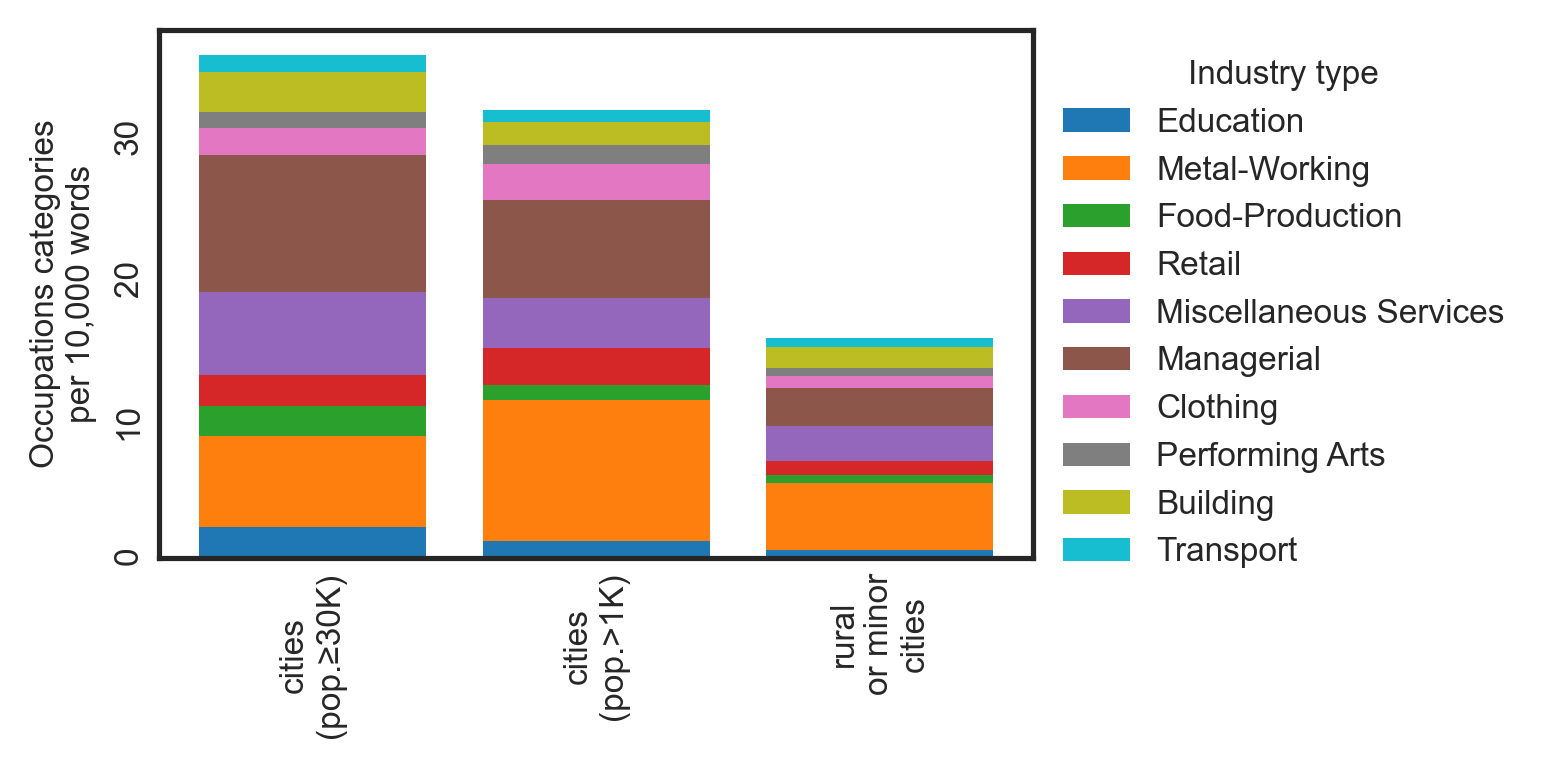

In [275]:
fig, ax = plt.subplots(figsize=[5.2,2.6], tight_layout=True)
first_bar_cat = list(edhcs_data_by_category.keys())[0]
ax.bar(labels, edhcs_data_by_category[first_bar_cat], label=first_bar_cat)
bottom = edhcs_data_by_category[first_bar_cat]

ax.tick_params(labelrotation=90)

for cat in list(edhcs_data_by_category.keys())[1:]:
    ax.bar(labels, edhcs_data_by_category[cat], bottom = bottom, label=cat)
    bottom += np.array(edhcs_data_by_category[cat])
ax.set_ylabel("Occupations categories\nper 10,000 words")
ax.legend(title="Industry type", bbox_to_anchor=(1, 1), fontsize=8)

In [276]:
save_figure(fig, "occups_industrytypes_context_bar")

A file with the same name ("occups_industrytypes_context_bar.eps") already exists in this location.
Your <class 'matplotlib.figure.Figure'> object has been succefully written as "https://sciencedata.dk/files/SDAM_root/SDAM_data/social_diversity/socdiv_figures/occups_industrytypes_context_bar.eps"
A file with the same name ("occups_industrytypes_context_bar.png") already exists in this location.
Your <class 'matplotlib.figure.Figure'> object has been succefully written as "https://sciencedata.dk/files/SDAM_root/SDAM_data/social_diversity/socdiv_figures/occups_industrytypes_context_bar.png"


## alternative urban contexts

In [57]:
edhcs_occups_cats_data = {}
contexts = ["large", "medium", "small", "rural"]
labels = ["large city", "medium city", "small city", "rural area"]

edhcs_all_present_categories = []
for context, label in zip(
    contexts,
    labels
):
    df_subset = LIRE[LIRE["urban_context_alt"]==context]
    occups_cats_list = [el for sublist in df_subset["occups_cats"].tolist() for el in sublist]
    wordcount = df_subset["clean_text_interpretive_word"].astype("str").apply(lambda x: len(x.split())).sum()
    occups_cats_dist = nltk.FreqDist(occups_cats_list).most_common()
    categories = [tup[0] for tup in occups_cats_dist]
    edhcs_all_present_categories.extend(categories[:10])
    freqs = [(tup[1] / wordcount) * 10000 for tup in occups_cats_dist]
    cat_freq_dict = dict(zip(categories[:10], freqs[:10]))
    total_freq = np.sum(freqs)
    edhcs_occups_cats_data[label] = {"categories" : categories, "freqs" : freqs, "cat_freq_dict" : cat_freq_dict,"total_freq" : total_freq}
    print(categories, freqs, total_freq)
edhcs_all_present_categories = list(set(edhcs_all_present_categories))

['Managerial', 'Metal-Working', 'Miscellaneous Services', 'Building', 'Food-Production', 'Education', 'Retail', 'Clothing', 'Transport', 'Performing Arts', 'Finance', 'Plastic Arts', 'Food-Retail', 'Household Goods', 'Water-Management', 'Glass-Working', 'Unclear meaning', 'Fuel / Raw material'] [9.546437470834567, 6.282958846619554, 5.8407117433380815, 2.790731720707229, 2.1654858160679047, 2.1502359159547506, 2.119736115728442, 1.8757377139179738, 1.189492208826032, 1.113242708260261, 0.5794962042998618, 0.5032467037340905, 0.4879968036209363, 0.3812475028288565, 0.16774890124469685, 0.10674930079207981, 0.045749700339462775, 0.015249900113154259] 37.36225527722794
['Metal-Working', 'Managerial', 'Miscellaneous Services', 'Retail', 'Clothing', 'Performing Arts', 'Building', 'Food-Production', 'Education', 'Transport', 'Finance', 'Plastic Arts', 'Food-Retail', 'Household Goods', 'Water-Management', 'Unclear meaning', 'Glass-Working'] [8.239336618327691, 6.237039730633532, 3.70539998757

In [58]:
edhcs_data_by_category = {}
for cat in edhcs_all_present_categories:
    cat_data = []
    for label in labels:
        try:
            cat_data.append(edhcs_occups_cats_data[label]["cat_freq_dict"][cat])
        except:
            cat_data.append(0)
    edhcs_data_by_category[cat] = cat_data
edhcs_data_by_category

{'Clothing': [1.8757377139179738,
  2.1403863282247912,
  2.720694844799857,
  0.8032725920416512],
 'Education': [2.1502359159547506,
  1.150745337755264,
  1.3431278347746127,
  0.4462625511342506],
 'Miscellaneous Services': [5.8407117433380815,
  3.7053999875719503,
  2.7895731953011187,
  2.4990702863518037],
 'Retail': [2.119736115728442,
  3.4752509200208976,
  0.7921010307645153,
  1.0710301227222014],
 'Building': [2.790731720707229,
  1.3348645917961064,
  1.8597154635340793,
  1.5172926738564523],
 'Managerial': [9.546437470834567,
  6.237039730633532,
  7.3011051531337925,
  2.2610635924135365],
 'Metal-Working': [6.282958846619554,
  8.239336618327691,
  10.986096904951319,
  4.819635552249907],
 'Transport': [1.189492208826032,
  0.7594919229184743,
  0.9298577317670397,
  0.5652658981033841],
 'Food-Production': [2.1654858160679047,
  1.311849685041001,
  0.688783505012622,
  0.4462625511342506],
 'Performing Arts': [1.113242708260261,
  1.3808944053063168,
  1.377567010

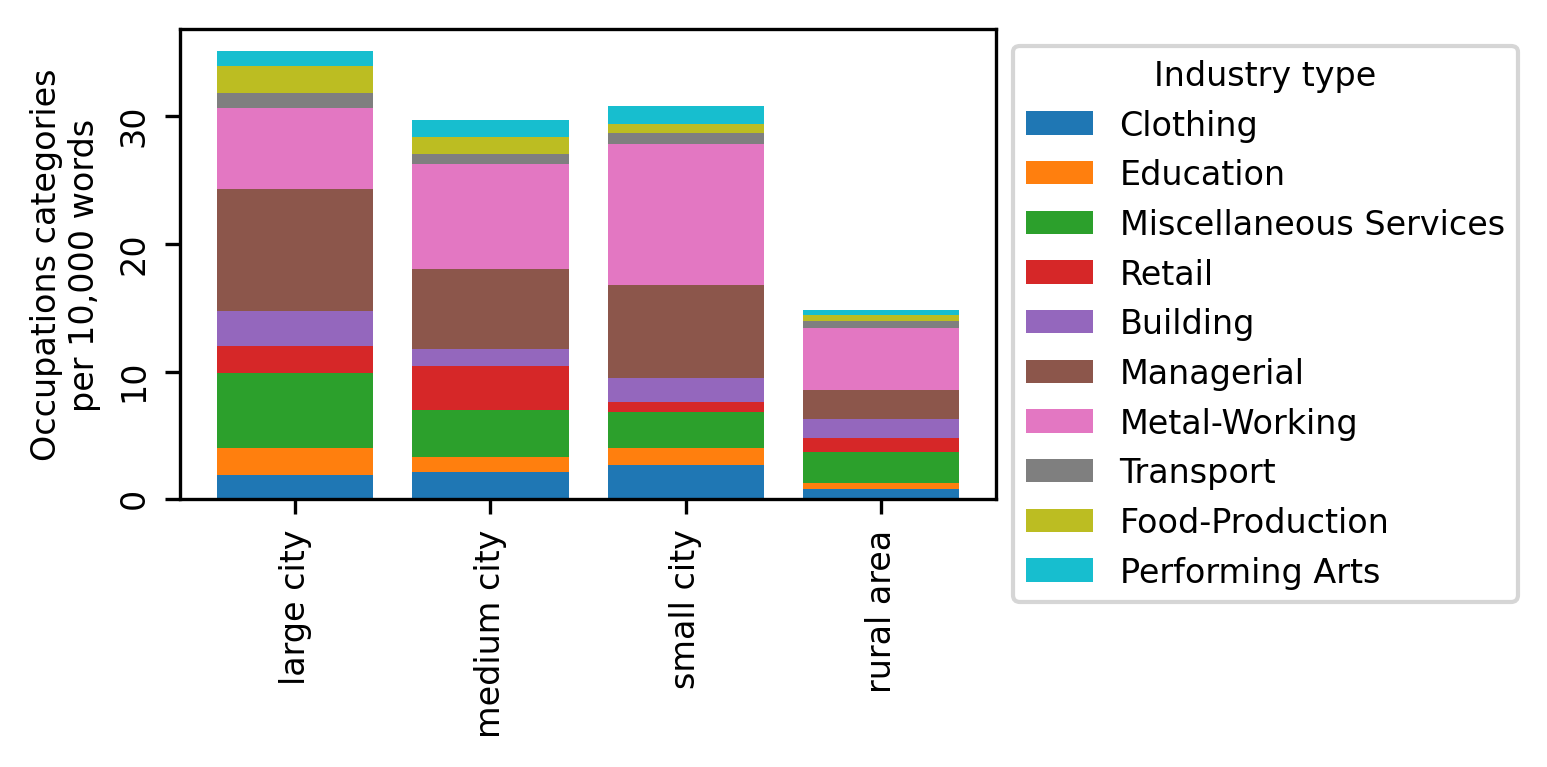

In [59]:
fig, ax = plt.subplots(figsize=[5.2,2.6], tight_layout=True)
first_bar_cat = list(edhcs_data_by_category.keys())[0]
ax.bar(labels, edhcs_data_by_category[first_bar_cat], label=first_bar_cat)
bottom = edhcs_data_by_category[first_bar_cat]

ax.tick_params(labelrotation=90)

for cat in list(edhcs_data_by_category.keys())[1:]:
    ax.bar(labels, edhcs_data_by_category[cat], bottom = bottom, label=cat)
    bottom += np.array(edhcs_data_by_category[cat])
ax.set_ylabel("Occupations categories\nper 10,000 words")

ax.legend(title="Industry type", bbox_to_anchor=(1, 1), fontsize=8)

In [60]:
save_figure(fig, "occups_industrytypes_context_alt_bar")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


A file with the same name ("occups_industrytypes_context_alt_bar.eps") already exists in this location.


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Your <class 'matplotlib.figure.Figure'> object has been succefully written as "https://sciencedata.dk/files/SDAM_root/SDAM_data/social_diversity/socdiv_figures/occups_industrytypes_context_alt_bar.eps"
A file with the same name ("occups_industrytypes_context_alt_bar.png") already exists in this location.
Your <class 'matplotlib.figure.Figure'> object has been succefully written as "https://sciencedata.dk/files/SDAM_root/SDAM_data/social_diversity/socdiv_figures/occups_industrytypes_context_alt_bar.png"


## Hisco categories

In [61]:
occupations_df = pd.read_csv("../data/occupations_list_hisco.csv")
occupations_df.head(5)

,Term,gen_sg,Vocab_nom_sg,Source,HISCO_majorgroup,HISCO_minorgroup,Harris_Category,Subcategory,Translation_eng
0,abetarius,i,NaN,Petrikovits 1981a,8.0,81.0,Building,Wood worker,"a joiner, wood worker"
1,abietarius,i,NaN,Petrikovits 1981a,8.0,81.0,Building,Wood worker,"a joiner, wood worker"
2,acceptor,oris,acceptor,Waltzing - Rome,3.0,31.0,Finance,NaN,"collector, gold quality checker"
3,accomodator,oris,NaN,Petrikovits 1981a,9.0,99.0,Unclear meaning,NaN,"uncertain, craftsman"
4,aceptor,oris,NaN,Petrikovits 1981a,3.0,31.0,Finance,NaN,"collector, gold quality checker"


In [62]:
occupations_df["Term"] = occupations_df["Term"].apply(lambda x: x.replace(" ", "_"))

In [63]:
hisco_cats_dict = {
    0.0 : "Professional, technical and related workers",
    1.0 : "Professional, technical and related workers",
    2.0 : "Administrative and managerial workers",
    3.0 : "Clerical and related workers",
    4.0 : "Sales workers",
    5.0 : "Service workers",
    6.0 : "Agricultural, animal husbandry and forestry workers, fishermen and hunters",
    7.0 : "Production and related workers, transport equipment operators and labourers",
    8.0 : "Production and related workers, transport equipment operators and labourers",
    9.0 : "Production and related workers, transport equipment operators and labourers",
}

In [64]:
hisco_cats_labels = list(set(hisco_cats_dict.values())) + ["unclassified"]
hisco_cats_labels

['Professional, technical and related workers',
 'Agricultural, animal husbandry and forestry workers, fishermen and hunters',
 'Production and related workers, transport equipment operators and labourers',
 'Administrative and managerial workers',
 'Service workers',
 'Clerical and related workers',
 'Sales workers',
 'unclassified']

In [65]:
def hisco_literary(hisco_code):
    try:
        return hisco_cats_dict[float(hisco_code)]
    except:
        return "unclassified"
occupations_df["hisco_cats"] = occupations_df["HISCO_majorgroup"].apply(hisco_literary)

In [66]:
occups_cats_dict = dict(zip(occupations_df["Term"], occupations_df["hisco_cats"]))
def cat_for_occup(list_of_occups):
    try:
        return [occups_cats_dict[occup] for occup in list_of_occups]
    except:
        return []
LIRE["occups_cats"] = LIRE["occups"].apply(cat_for_occup)

In [67]:
edhcs_occups_cats_data = {}

contexts = ["large", "medium", "small", "rural"]
labels = ["large city", "medium city", "small city", "rural area"]

edhcs_all_present_categories = []
for context, label in zip(
    contexts,
    labels
):
    df_subset = LIRE[LIRE["urban_context_alt"]==context]
    occups_cats_list = [el for sublist in df_subset["occups_cats"].tolist() for el in sublist]
    wordcount = df_subset["clean_text_interpretive_word"].astype("str").apply(lambda x: len(x.split())).sum()
    occups_cats_dist = nltk.FreqDist(occups_cats_list).most_common()
    categories = [tup[0] for tup in occups_cats_dist]
    edhcs_all_present_categories.extend(categories[:10])
    freqs = [(tup[1] / wordcount) * 10000 for tup in occups_cats_dist]
    cat_freq_dict = dict(zip(categories[:10], freqs[:10]))
    total_freq = np.sum(freqs)
    edhcs_occups_cats_data[label] = {"categories" : categories, "freqs" : freqs, "cat_freq_dict" : cat_freq_dict,"total_freq" : total_freq}
    print(categories, freqs, total_freq)
edhcs_all_present_categories = list(set(edhcs_all_present_categories))

['Production and related workers, transport equipment operators and labourers', 'Administrative and managerial workers', 'Professional, technical and related workers', 'Service workers', 'Clerical and related workers', 'Sales workers', 'Agricultural, animal husbandry and forestry workers, fishermen and hunters', 'unclassified'] [12.703166794257497, 9.393938469703023, 5.123966438019831, 3.4007277252334, 2.6839824199151496, 2.516233518670453, 0.9302439069024098, 0.045749700339462775] 36.79800897304123
['Production and related workers, transport equipment operators and labourers', 'Administrative and managerial workers', 'Professional, technical and related workers', 'Sales workers', 'Clerical and related workers', 'Service workers', 'Agricultural, animal husbandry and forestry workers, fishermen and hunters', 'unclassified'] [13.233571384185538, 5.9838757563273735, 4.2807726564495825, 3.8665043348576877, 1.9102372606737383, 1.3348645917961064, 0.6904472026531584, 0.02301490675510528] 31.

In [68]:
edhcs_occups_cats_data

{'large city': {'categories': ['Production and related workers, transport equipment operators and labourers',
   'Administrative and managerial workers',
   'Professional, technical and related workers',
   'Service workers',
   'Clerical and related workers',
   'Sales workers',
   'Agricultural, animal husbandry and forestry workers, fishermen and hunters',
   'unclassified'],
  'freqs': [12.703166794257497,
   9.393938469703023,
   5.123966438019831,
   3.4007277252334,
   2.6839824199151496,
   2.516233518670453,
   0.9302439069024098,
   0.045749700339462775],
  'cat_freq_dict': {'Production and related workers, transport equipment operators and labourers': 12.703166794257497,
   'Administrative and managerial workers': 9.393938469703023,
   'Professional, technical and related workers': 5.123966438019831,
   'Service workers': 3.4007277252334,
   'Clerical and related workers': 2.6839824199151496,
   'Sales workers': 2.516233518670453,
   'Agricultural, animal husbandry and fores

In [69]:
hisco_cats_labels = [
    "Professional, technical and related workers",
    "Administrative and managerial workers",
    "Clerical and related workers",
    "Sales workers",
    "Service workers",
    "Agricultural, animal husbandry and forestry workers, fishermen and hunters",
    "Production and related workers, transport equipment operators and labourers",
    "unclassified"
]

In [70]:
edhcs_data_by_category = {}
for cat in hisco_cats_labels:
    cat_data = []
    for label in labels:
        try:
            cat_data.append(edhcs_occups_cats_data[label]["cat_freq_dict"][cat])
        except:
            cat_data.append(0)
    edhcs_data_by_category[cat] = cat_data
edhcs_data_by_category

{'Professional, technical and related workers': [5.123966438019831,
  4.2807726564495825,
  3.5816742260656342,
  1.8148010412792859],
 'Administrative and managerial workers': [9.393938469703023,
  5.9838757563273735,
  7.197787627381899,
  2.2610635924135365],
 'Clerical and related workers': [2.6839824199151496,
  1.9102372606737383,
  1.7908371130328171,
  0.5355150613611007],
 'Sales workers': [2.516233518670453,
  3.8665043348576877,
  0.9642969070176707,
  1.190033469691335],
 'Service workers': [3.4007277252334,
  1.3348645917961064,
  0.8609793812657774,
  0.3272592041651171],
 'Agricultural, animal husbandry and forestry workers, fishermen and hunters': [0.9302439069024098,
  0.6904472026531584,
  0.37883092775694205,
  0.26775753068055036],
 'Production and related workers, transport equipment operators and labourers': [12.703166794257497,
  13.233571384185538,
  16.806317522307975,
  8.71699516548903],
 'unclassified': [0.045749700339462775, 0.02301490675510528, 0, 0]}

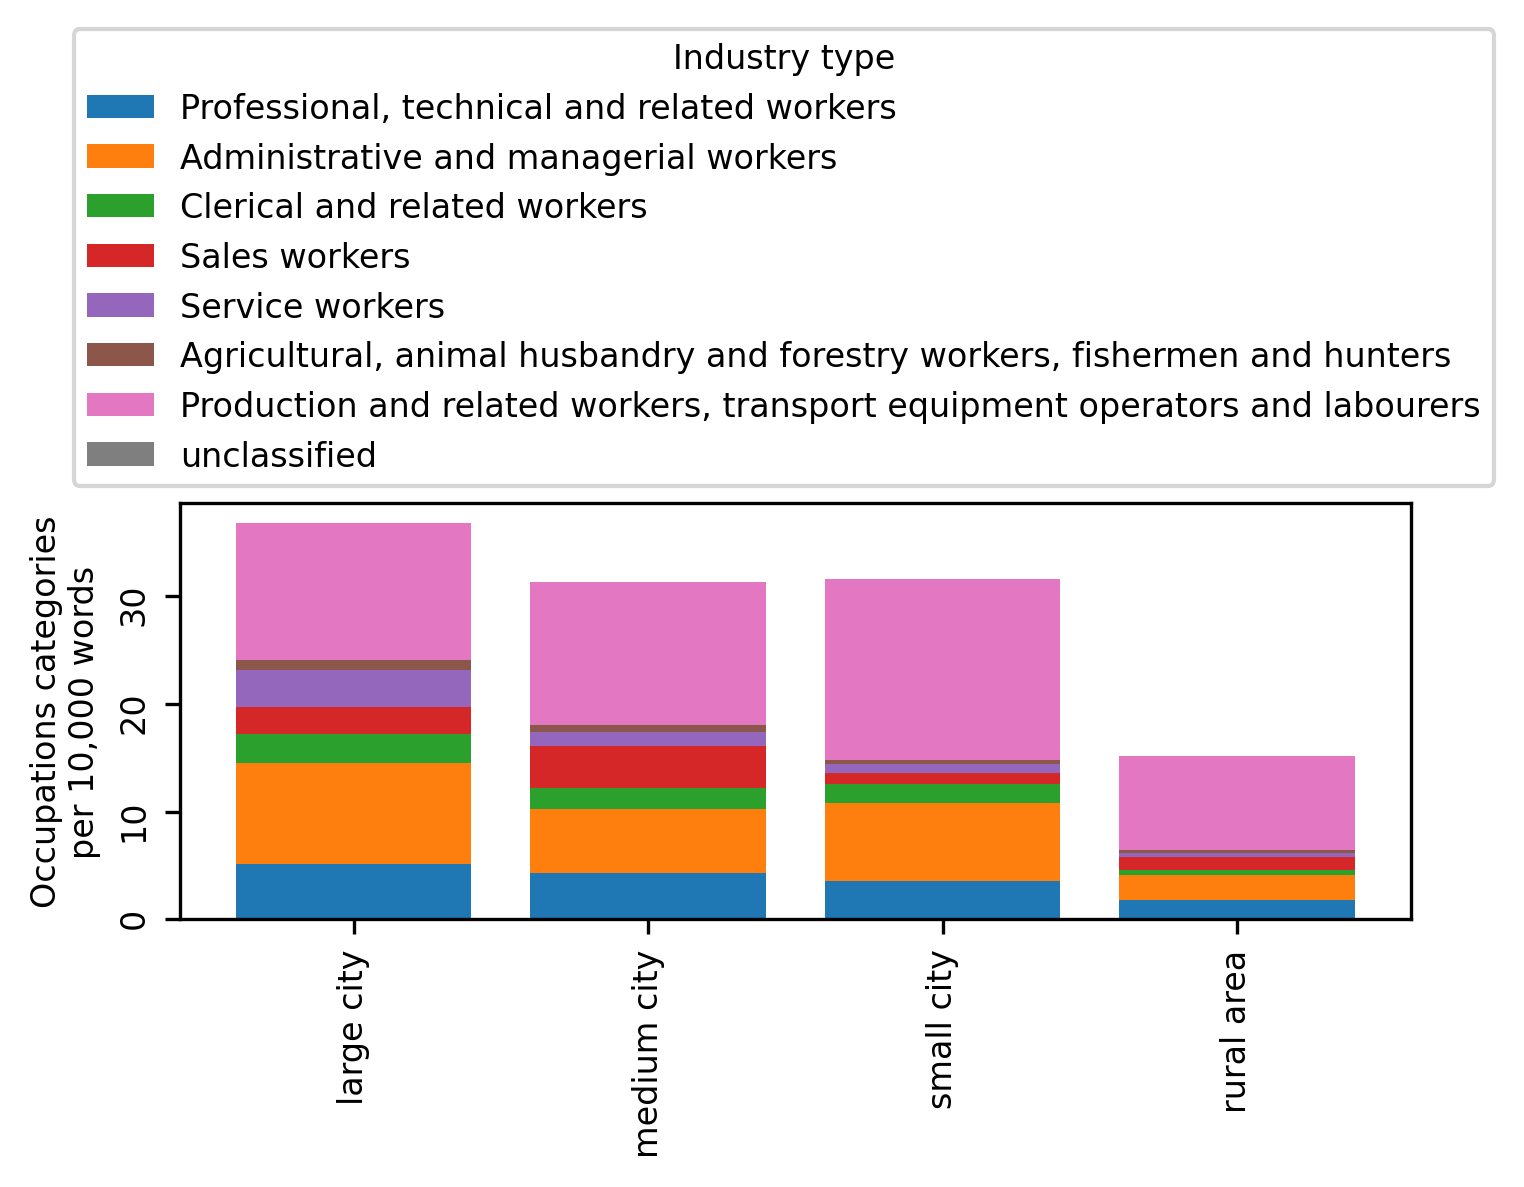

In [75]:
fig, ax = plt.subplots(figsize=[5.2,4], tight_layout=True)
first_bar_cat = hisco_cats_labels[0]

ax.bar(labels, edhcs_data_by_category[first_bar_cat], label=first_bar_cat)
bottom = edhcs_data_by_category[first_bar_cat]

ax.tick_params(labelrotation=90)

for cat in hisco_cats_labels[1:]:
    ax.bar(labels, edhcs_data_by_category[cat], bottom = bottom, label=cat)
    bottom += np.array(edhcs_data_by_category[cat])
ax.set_ylabel("Occupations categories\nper 10,000 words")
ax.legend(title="Industry type", bbox_to_anchor=(-0.1, 1), loc="lower left", fontsize=8)

In [76]:
save_figure(fig, "occups_industrytypes_context_alt_bar")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


A file with the same name ("occups_industrytypes_context_alt_bar.eps") already exists in this location.


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Your <class 'matplotlib.figure.Figure'> object has been succefully written as "https://sciencedata.dk/files/SDAM_root/SDAM_data/social_diversity/socdiv_figures/occups_industrytypes_context_alt_bar.eps"
A file with the same name ("occups_industrytypes_context_alt_bar.png") already exists in this location.
Your <class 'matplotlib.figure.Figure'> object has been succefully written as "https://sciencedata.dk/files/SDAM_root/SDAM_data/social_diversity/socdiv_figures/occups_industrytypes_context_alt_bar.png"


In [77]:
LIRE.to_parquet("../data/large_data/LIRE_occupsorgs_cats.parquet")